![MCX Banner](https://mcx.space/img/mcx18_banner.png)

# » Getting Started with MCXLAB

- **Author**: Qianqian Fang (q.fang at neu.edu) http://fanglab.org
- **MCX Website**: https://mcx.space
- **License**: GNU Public License V3 or later
- **Github**: https://github.com/fangq/mcx

Monte Carlo eXtreme (MCX) is a <font color='green'>GPU-accelerated, physically-accurate, and open-source</font> photon transport simulaion platform funded by the US National Institute of Health under grant [R01-GM114365](https://grantome.com/grant/NIH/R01-GM114365-06). By taking advantage of the massively parallel threads and extremely low memory latency in a modern graphics processing unit (GPU), MCX is capable of performing Monte Carlo (MC) photon simulations at a blazing speed, typically hundreds to a thousand times faster than a fully optimized CPU-based MC implementation.

MCXLAB is the native MATLAB/GNU Octave bindings (interface) for running MCX GPU-accelerated photon simulations inside MATLAB or [GNU Octave](https://octave.org) - an open-source MATLAB clone.

In this tutorial, we use Octave to demonstrate the basic usage of MCXLAB, but the exact commands can also be executed inside MATLAB.

## Step 0: setting up Octave environment (only needed for Google Colab)

> Only need to run this once at the beginning - this step may take 4-5 min to complete

To run interactive Octave sessions inside a Google Colab Jupyter Notebook environment, we need to install the following dependencies
- GNU Octave via `sudo apt-get install octave`
- Oct2py Python module via `pip install oct2py`, and
- enable Oct2py in Google Colab via "magic command" `%load_ext oct2py.ipython`

If you run this on Google Colab, please go to menu **Edit\Notebook Settings\Hardware accelerator**, and verify if it has already selected "GPU".

**Please note**: MCX/MCXLAB is GPU-accelerated. This notebook by default requests an NVIDIA GPU. Howevever, when you click on the run-button for the below section, your browser may fail to allocate a GPU runtime and ask you if you want to continue with a non-GPU runtime. If you choose to proceed without GPU support, you will have to run the section immediately following the next section to install OpenCL-based MCXLAB (called mcxlabcl) and utilize the CPU to run the rest of the tutorials. The OpenCL version of MCXLAB will work for all examples, but will be substentially slower to run (this tutorial also reduces the photon numbers accordingly to lower the runtime). 

In [ ]:
# Although you don't have to understand every command in this section, you do
# have to run this section once to set up the environment - it can take 4-5 mins
# to complete - just hit the run button, wait, and move on to the next section

######  Plan A - request Google Colab for a GPU and run CUDA based MCXLAB ######

# install octave and oct2py
!apt-get install octave      # install octave to Linux host
!pip install oct2py          # install oct2py Python module

# add octave support to colab notebook
%load_ext oct2py.ipython

# download and unzip mcxlab
!rm -rf mcxlab*
!wget http://mcx.space/nightly/release/git20211204/mcxlab-allinone-x86_64-git20211204.zip  # download mcxlab
!unzip mcxlab-allinone-x86_64-git20211204.zip && rm -rf mcxlab-allinone-x86_64-git20211204.zip # unzip mcxlab

# download jsonlab and zmat toolboxes for sharing data between MATLAB and Python
!git clone https://github.com/fangq/jsonlab.git  # download jsonlab
!git clone https://github.com/NeuroJSON/zmat.git # download zmat

If Google Colab failed to allocate you a GPU enabled runtime (it will popup a dialog), you can **still run this tutorial** by executing the below section - which downloads the OpenCL version of MCXLAB - mcxlabcl - and run all simulations on the CPU (much slower)

In [2]:
%%bash
######  Plan B - if one fails to get a GPU, install OpenCL based MCXLAB ########
if [[ ! -f `which nvidia-smi` ]]; then   # if no GPU available, install mcxlabcl (OpenCL version of mcxlab)
    apt-get install libpocl2 pocl-opencl-icd                                    # install OpenCL Linux runtime
    rm -rf mcxlabcl*
    wget http://mcx.space/nightly/github/mcxlabcl-linux-x64-github-latest.zip   # download mcxlabcl
    unzip mcxlabcl-linux-x64-github-latest.zip                                  # unzip mcxlabcl
fi

## Step 1: Add mcxlab path to Octave

---

> Only need to run this once at the beginning


In [ ]:
%%octave
addpath([pwd filesep 'mcxlab']);                 % add path to mcx
addpath([pwd filesep 'mcxlab' filesep 'utils']); % add path to mcx helper functions
addpath([pwd filesep 'jsonlab']);                % optional: add path to jsonlab for data export
addpath([pwd filesep 'zmat']);                   % optional: add path to zmat for data compression

if(system('which nvidia-smi'))                   % if this runtime does not have NVIDIA GPU support
    addpath([pwd filesep 'mcxlabcl']);           % add path to mcxlabcl
    USE_MCXCL=1;                                 % set USE_MCXCL flag in the base workspace
end

## Step 2: List your available GPU or CPU for MCXLAB

---

In [4]:
%%octave
which mcx
mcxlab('gpuinfo')                        % use this command to list supported CPU or GPU

'mcx' is a function from the file /content/mcxlab/octave/gnu-linux-x86_64/mcx.mex

=============================   GPU Information  ================================

Device 1 of 1:		Tesla T4

Compute Capability:	7.5

Global Memory:		15835398144 B

Constant Memory:	65536 B

Shared Memory:		49152 B

Registers:		65536

Clock Speed:		1.59 GHz

Number of SMs:		40

Number of Cores:	2560

Auto-thread:		81920

Auto-block:		64

ans =

  scalar structure containing the fields:

    name = Tesla T4

    id =  1

    devcount =  1

    major =  7

    minor =  5

    globalmem =  15835398144

    constmem =  65536

    sharedmem =  49152

    regcount =  65536

    clock =  1590000

    sm =  40

    core =  2560

    autoblock =  64

    autothread =  81920

    maxgate = 0

## Step 3: Define simulation (using a `cfg` struct)

---



In [5]:
%%octave
clear cfg

% the below fields are minimumally required to define an MCX simulation
cfg.nphoton=1e7;                   % define how many photon packets to simulate
cfg.vol=uint8(ones(60,60,60));     % define a label-based volume - each voxel has a integer defining the medium type
cfg.vol(20:40, 30:40, 20:30)=2;    % adding an inclusion by setting to a different label
cfg.srcpos=[30 30 1];              % source position in voxel-units
cfg.srcdir=[0 0 1];                % source direction (default source type is a pencil beam)
cfg.prop=[0 0 1 1;                 % cfg.prop defines the optical properties, one medium per row; first row is for medium label 0 (background)
          0.005 1 0 1.37;          % cfg.prop has 4 columns, in the order [mua(1/mm), mus(1/mm), g(anisotropy), n(ref index)]; 2nd row for medium type 1
          0.1, 10, 0.9, 1];        % third row is for medium type 2, and so on
cfg.tstart=0;                      % define the start time of the simulation (in s)
cfg.tend=5e-9;                     % define the maximum duration of the photon packet (in s)
cfg.tstep=5e-9;                    % define the time gate (step size) of the output, if tstep=tend as a large time window,this produces a CW solution
cfg.gpuid=1;                       % use the first GPU (default), can use strings of '01' masks to use multiple GPU, such as '0110'

% reduce photon number on runtimes without a GPU (CPU only)
if(exist('USE_MCXCL', 'var') && USE_MCXCL==1)  % if no GPU is found, run less photon on the CPU
    cfg.nphoton=1e5;               % define how many photon packets to simulate
end

##Step 4: Run mcxlab simulation

---
Running this section for the first time can be slightly slow as CUDA needs to initialize the GPU device. Running again should take less than a second.

In [ ]:
%%octave
% calculate the flux distribution with the given config
flux=mcxlab(cfg);

## Step 5: Visualize results

---

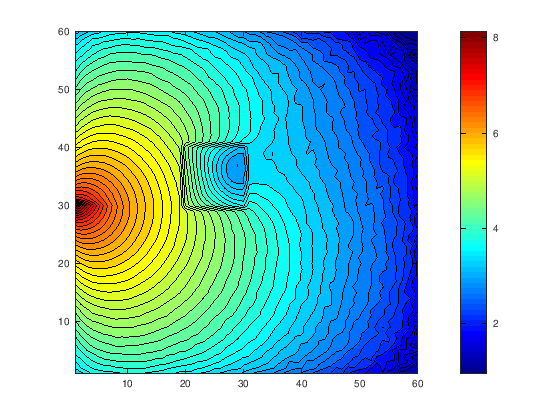

In [8]:
%%octave
contourf(log10(squeeze(flux.data(30,:,:,1))), 50);
axis equal
colorbar
colormap('jet')


# » Sharing MCXLAB data between software

## Export data to human-readable JSON/NeuroJSON formats for easy sharing

---
The US NIH-funded NeuroJSON Project (https://neurojson.org), also developed and led by MCX's author Dr. Fang, is aimed at breaking the barriers for sharing and reusing scientific data between diverse software and programming environments (such as MATLAB, Python, web etc). The NeuroJSON project envisons that the key for making valuable scientific data long-lasting and easily reusable is **human-readability**, thus has adopted JSON and binary JSON as the primary universal format to store data files. JSON is not only directly human-readable, but also readily supported across almost every existing programming language and by many software out-of-box.

![NeuroJSON logo](https://neurojson.org/wiki/upload/neurojson_banner_long.png)

To read/write NeuroJSON/JSON encoded data in MATLAB, one just need to download a lightweight (155kB zipped) toolbox -- JSONLab (https://github.com/fangq/jsonlab). This toolbox not only reads and writes JSON/binary JSON data files, but also encodes/decodes complex scientific data structures supported via the [JData specification](https://neurojson.org/jdata/).

![JSONLab logo](https://iso2mesh.sourceforge.net/upload/jsonlab-banner.png)

One can also use the built-in `jsonencode/jsondecode` functions provided in MATLAB (R2016+)/Octave (7+) to read all JSON based data files. If there are JData encoded data, one can then call `jdataencode/jdatadecode` functions in JSONLab to extract such data.

In [9]:
%%octave
% save to text-based JSON file and list file size
tic;savejd('', flux, 'filename', 'mcx_flux.json', 'compression', 'zlib');toc
system('ls -l mcx_flux.json');

% save to binary JSON file (*.jdb) and list file size
tic;savejd('', flux, 'filename', 'mcx_flux.jdb', 'compression', 'lzma');toc
system('ls -l mcx_flux.jdb');

% save to regular .mat file and list file size
tic;save('mcx_flux.mat', 'flux');toc
system('ls -l mcx_flux.mat');

% export MCXLAB cfg structure to a JSON file for later use
savejd('', cfg, 'filename', 'mcx_cfg.jdb', 'compression', 'zlib');

% export MCXLAB cfg structure to a JSON file as the standalone mcx binary input file
mcx2json(cfg, 'mcx_input');

Elapsed time is 0.106831 seconds.

-rw-r--r-- 1 root root 1086915 Apr 30 02:34 mcx_flux.json

Elapsed time is 0.207293 seconds.

-rw-r--r-- 1 root root 725389 Apr 30 02:34 mcx_flux.jdb

Elapsed time is 0.241601 seconds.

-rw-r--r-- 1 root root 3802917 Apr 30 02:34 mcx_flux.mat

## Loading MATLAB data in Python

---



To read/write JSON/NeuroJSON encoded universal data files in Python, one just need to install and import a tiny module called `jdata` (https://pypi.org/project/jdata/); another lightweight (~64 kB) module `bjdata` (https://pypi.org/project/bjdata/) allows one to read/write binary JSON files that supports many complex data structures.

In [ ]:
!pip install jdata bjdata      # jdata module is only 14 kB, bjdata module is only 64 kB
!pip install --upgrade numpy   # to avoid numpy version mismatch error in the next section
import jdata as jd

JSON/binary JSON encoded data files can be passed on from MATLAB to Python (and presumabily many other environments) by 

In [14]:
%%time
# now one can load NeuroJSON/JSON encoded complex data to other programs, such as Python
flux=jd.load('mcx_flux.json')
print([flux.keys(), flux['data'].dtype, flux['data'].shape])

flux=jd.load('mcx_flux.jdb')
print([flux.keys(), flux['data'].dtype, flux['data'].shape])
print(flux['stat'])

[dict_keys(['data', 'stat', 'dref', 'prop']), dtype('float32'), (60, 60, 60)]
[dict_keys(['data', 'stat', 'dref', 'prop']), dtype('float32'), (60, 60, 60)]
{'runtime': 592, 'nphoton': 10000000, 'energytot': 10000000, 'energyabs': 2728910.742012024, 'normalizer': 20, 'unitinmm': 1, 'workload': 2560}
CPU times: user 77.9 ms, sys: 435 µs, total: 78.3 ms
Wall time: 81.1 ms


## Loading MATLAB data in JavaScript

---



To read/write JSON/NeuroJSON encoded universal data files in Python, one just need to install and import a tiny module called `jda` (https://npmjs.com/package/jda); another lightweight (~34 kB) module `bjd` (https://npmjs.com/package/bjd) allows one to read/write binary JSON files that supports many complex data structures, more compact size and faster file parsing.

In [ ]:
!npm install jda bjd numjs atob btoa  # jda module is only 20 kB, bjd module is only 34 kB

JSON/binary JSON encoded data files can be passed on from MATLAB to JavaScript by

In [ ]:
%%javascript
// now one can load NeuroJSON/JSON encoded complex data to other programs, such as Python
var jdata = require('jda')
var nj = require('numjs')
var fs = require('fs')

// loading a JSON file with JSON.parse and then decode the data/array use jdata
var flux = new jdata(JSON.parse(fs.readFileSync('mcx_flux.json').toString().replace(/\n/g,''))).decode();
console.log([flux.data.dtype, flux.data.shape])

// loading a binary JSON file with bjd.decode() and then decode the data/array use jdata
var bjd = require('bjd')
var flux2 = new jdata(bjd.decode(fs.readFileSync('mcx_flux.jdb'))[0]).decode();
console.log([flux2.data.dtype, flux2.data.shape])

## Download .json file to local disk

---

In [ ]:
from google.colab import files
files.download('mcx_flux.json')

# once downloaded, you can then load this file to Python using jdata.load, 
# or loadjson or loadjd in MATLAB/Octave for local processing

# » Use detectors

## Setup detectors and detection flags

In [ ]:
%%octave
cfg.detpos=[30,27,0,1; 30,25,0,1];   # to detect photons, one must first define detectors, each row in detpos defines a detector with [x,y,z,radius]
cfg.issrcfrom0=1;                    # set this flag to ensure src/det coordinates align with voxel space

## Run simulation, detected photons are stored in `res['detp']`

In [ ]:
%%octave
[flux, detp]=mcxlab(cfg);

## Display histogram of partial-paths

---



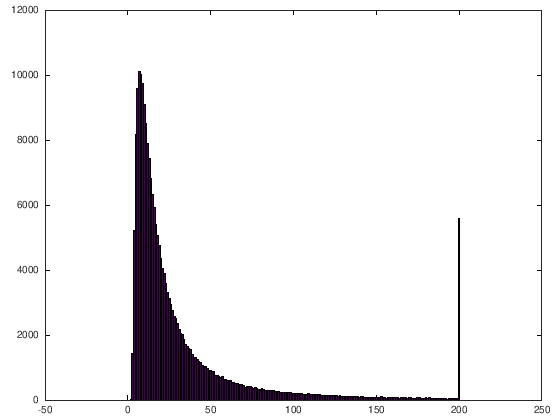

In [ ]:
%%octave
hist(detp.ppath(:,1), 0:1:200);

## Use `savedetflag` to save multiple output data types

---
in the below example, we ask mcx to output detected photon specific data according to the letters presented in the `savedetflag` string:

- `d`: detected photon ID (starting from 1), width: 1, output field: `detid`
- `p`: partial path for each medium type, width: #media output field: `ppath`
- `x`: detected photon existing position, width: 3,  output field: `p`

other possible flags include
- `s`: partial scattering count per medium, width: #media,  output field: `nscat`
- `v`: existing direction vector, width: 3,  output field: `v`
- `m`: momentum transfer per medium, width: #media,  output field: `mom`
- `w`: photon initial weight, width: 1,  output field: `w0`

In [ ]:
%%octave
cfg.savedetflag='dpx';

In [ ]:
%%octave
[flux, detp]=mcxlab(cfg);

% detected 
fieldnames(detp)

## Plot detected photon existing positions

---



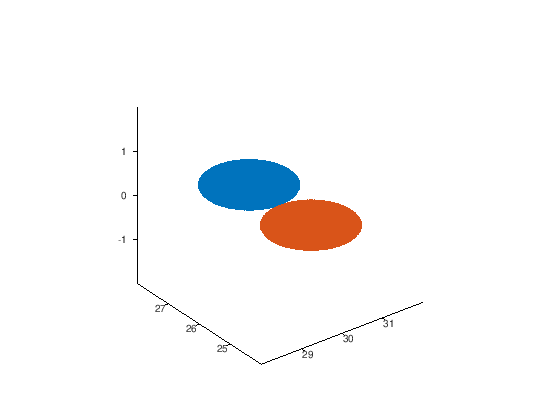

In [ ]:
%%octave
% plot photon existing position for Det#1 in red
pos1=detp.p(detp.detid==1,:);
plot3(pos1(:,1), pos1(:,2), pos1(:,3))

% plot photon existing position for Det#2 in blue
pos2=detp.p(detp.detid==2,:);
hold on;
plot3(pos2(:,1), pos2(:,2), pos2(:,3))

axis equal

## Save both fluence and detected photon data to disk

---



In [ ]:
%%octave
mcxoutput=struct('flux', flux, 'detp', detp);
tic;savejd('', mcxoutput, 'filename', 'mcx_flux_dept.json', 'compression', 'zlib');toc
system('ls -l mcx_flux_dept.json');

tic;save('mcx_flux_dept.mat', 'mcxoutput');toc
system('ls -l mcx_flux_dept.mat');

Elapsed time is 1.29467 seconds.

-rw-r--r-- 1 root root 9792181 Apr 28 19:24 mcx_flux_dept.json

Elapsed time is 3.2799 seconds.

-rw-r--r-- 1 root root 41703987 Apr 28 19:24 mcx_flux_dept.mat

In [ ]:
%%time
# now one can load NeuroJSON/JSON encoded complex data to other programs, such as Python
flux=jd.load('mcx_flux_dept.json')
flux['detp'].keys()

## Download output file

---



In [ ]:
from google.colab import files
files.download('mcx_flux_dept.json')

# » Save diffuse reflectance

## Padding volume by zeros to save diffuse reflectance

---

mcx can accumulate a photon's remaining weight upon exiting the domain surface. The accumulated distribution can be used to compute "diffuse reflectance" (`dref`). However, mcx only accumulates `dref` in 0-valued voxels (i.e. background).

That means in order to save `dref` along any medium surface, one must pad a layer of zero voxels outside of this surface.

In the below example, we set voxels in z=0 plane to be 0s, so we can capture photons escaping from z=1 plane.

The saved "diffuse reflectance" are stored under the `dref` key of the output dictonary object.

In [ ]:
%%octave
cfg.vol(:,:,1)=0;
cfg.issaveref=1;

[flux, detp]=mcxlab(cfg);

fieldnames(flux)

Launching MCXLAB - Monte Carlo eXtreme for MATLAB & GNU Octave ...

Running simulations for configuration #1 ...

mcx.nphoton=1e+07;

mcx.dim=[60 60 60];

mcx.mediabyte=1;

mcx.srcpos=[30 30 1];

mcx.srcdir=[0 0 1 0];

mcx.medianum=3;

mcx.tstart=0;

mcx.tend=5e-09;

mcx.tstep=5e-09;

mcx.gpuid=1;

mcx.detnum=2;

mcx.issrcfrom0=1;

mcx.savedetflag=21;

mcx.issaveref=1;

###############################################################################

#                      Monte Carlo eXtreme (MCX) -- CUDA                      #

#          Copyright (c) 2009-2022 Qianqian Fang <q.fang at neu.edu>          #

#                             http://mcx.space/                               #

#                                                                             #

# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #

#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #

###############################################################################

#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #

###############################################################################

$Rev::a7a459$v2022.10$Date::2023-04-23 18:09:01 -04$ by $Author::Qianqian Fang$

###############################################################################

- variant name: [Fermi] compiled by nvcc [11.3] with CUDA [11030]

- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=1 (Tesla T4) threadph=122 extra=5760 np=10000000 nthread=81920 maxgate=1 repetition=1

initializing streams ...	init complete : 0 ms

requesting 1536 bytes of shared memory

launching MCX simulation for time window [0.00e+00ns 5.00e+00ns] ...

simulation run# 1 ...

kernel complete:  	645 ms

retrieving fields ... 	detected 0 photons, total: 0	transfer complete:	654 ms

normalizing raw data ...	source 1, normalization factor alpha=20.000000

data normalization complete : 660 ms

simulated 10000000 photons (10000000) with 81920 threads (repeat x1)

MCX simulation speed: 16103.06 photon/ms

total simulated energy: 10000000.00	absorbed: 27.32924%

(loss due to initial specular reflection is excluded in the total)

ans =

{

  [1,1] = data

  [2,1] = stat

  [3,1] = dref

  [4,1] = prop

}

ans =  0.86947

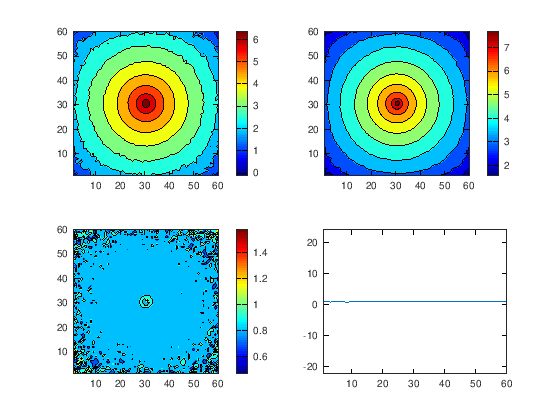

In [ ]:
%%octave
figure;
subplot(221);
contourf(log10(flux.dref(:, :, 1)))  % plot diffuse reflectance (outer) at z=1 interface
colorbar()
colormap('jet')
axis equal

subplot(222);
contourf(log10(flux.data(:, :, 2)))  % plot fluence (inner) at z=1 interface
colorbar()
colormap('jet')
axis equal

subplot(223);
contourf(log10(flux.data(:, :, 2)) - log10(flux.dref(:, :, 1))) % plot fluence/dref
colorbar()
colormap('jet')
axis equal

subplot(224);
plot(squeeze(log10(flux.data(30, :, 2)) - log10(flux.dref(30, :, 1))))
mean(squeeze(log10(flux.data(30, :, 2)) - log10(flux.dref(30, :, 1))))
axis equal

# » Photon replay

For details related to the "photon replay" algorithm, please check out our below paper:

* Ruoyang Yao, Xavier Intes, Qianqian Fang*, ["A direct approach to compute Jacobians for diffuse optical tomography using perturbation Monte Carlo-based photon 'replay',"](https://www.osapublishing.org/boe/abstract.cfm?uri=boe-9-10-4588) Biomed. Optics Express 9(10), 4588-4603, (2018)


## Using *photon replay* to build Jacobians

In [ ]:
%%octave

%% Step 1 - run baseline simulation to get detected photons (and their seeds) at detectors
clear cfg
cfg.nphoton=1e7;
cfg.vol=uint8(ones(60,60,60));
cfg.vol(20:40, 30:40, 20:30)=2;
cfg.srcpos=[30 30 1];
cfg.srcdir=[0 0 1];
cfg.prop=[0 0 1 1; 0.005 1 0 1.37; 0.1, 10, 0.9, 1];
cfg.tstart=0;
cfg.tend=5e-9;
cfg.tstep=5e-9;
cfg.gpuid=1;
cfg.detpos=[30,20,0,1];        % to detect photons, one must first define detectors
cfg.issrcfrom0=1;              % set this flag to ensure src/det coordinates align with voxel space

if(exist('USE_MCXCL', 'var') && USE_MCXCL)
    cfg.nphoton=1e5;
end

% run baseline simulation, now seed data are stored in output seeds.data
[flux, detp, vol, seeds]=mcxlab(cfg);
size(seeds.data)

In [ ]:
%%octave

% Step 2 - replay detected photon and output Jacobian
cfg_replay=cfg;
cfg_replay.seed=seeds.data;              % one must define cfg.seed using the returned seeds
cfg_replay.detphotons=detp.data;    % one must define cfg.detphotons. using the returned detp data
cfg_replay.outputtype='jacobian';   % tell mcx to output absorption (mu_a) Jacobian

# run replay, if done properly, the exact the same set of photons will be "redetected"
[flux2, detp2, vol2, seeds2]=mcxlab(cfg_replay);
disp(struct('redetection', size(seeds2.data), 'initial_detection', size(seeds.data)))

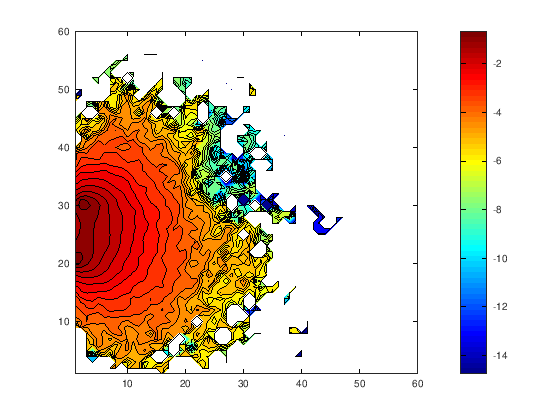

In [ ]:
%%octave

% plot mu_a Jacobian (sensitivity profile, or photon banana)
contourf(log10(squeeze(flux2.data(30,:, :))), 40)
colorbar();
colormap('jet');
axis equal

# » Define domain by JSON based shape descriptors

## Define domain by a series of shape constructs

---


In [ ]:
%%octave

Shapes={};
Shapes{end+1}=struct('Grid', struct('Tag', 1, 'Size', [40,60,30]));
Shapes{end+1}=struct('Sphere', struct('Tag', 2, 'O', [20,30,10], 'R', 10));

cfg.shapes=savejson('Shapes', Shapes, 'compact', 1);

cfg.shapes

% alternatively, one can also directly define cfg.shapes as a JSON string such as
% cfg.shapes= '{"Shapes":[{"Grid":{"Tag":1,"Size":[40,60,30]}},{"Sphere":{"Tag":2,"O":[20,30,10],"R":10}}]}';

cfg.srcpos=[20,30,0];
cfg.prop=[0, 0, 1, 1; 0.005, 1, 0.01, 1.37; 0.1, 10, 0.9, 1];

In [ ]:
%%octave
flux=mcxlab(cfg);

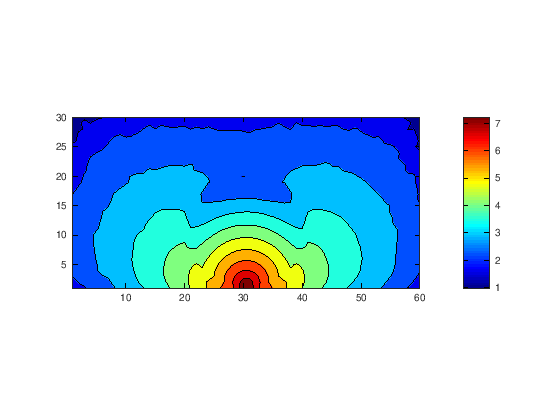

In [ ]:
%%octave

contourf(log10(abs(squeeze(flux.data(20,:,:))')))
colorbar;
colormap('jet')
axis equal

# » Track photon trajectories

**WARNING! Returning photon trajectories is a feature largely used for debugging and visualization purposes. Because it is such an intuitive output, it has been mis-used numerously by new users for deriving quantiative metrics.**

We strongly do not recommend the use of this output for deriving other quantities unless you know exactly what you are looking for. The reasons for this recommendation are

- trajectory data require a very large memory footprint to store and process, thus is very inefficient; they may not even fit in the GPU memory
- each segment in the trajectories is not the same - they are associated with spatially varying packet weight; to rigirously consider such weight changes along the path requires complex math
- the fluence and detected photon data mcxlab returns are essentially derived from tracking photons entire paths in the GPU; what you are looking for may already been returned as part of combinations of these outputs; there is no need to recompute these quantities on the CPU by repeating the same process (which is much more efficient on the GPU).

## Obtain photon trajectories

---

If one asks mcxlab to return a 5th output, an 6xN matrix will be returned; each colume represents the state of a photon when a scattering happens. The total number of scattering event summing across all simulated photons can not exceed a limit set by `cfg.maxjumpdebug`, which as a default value of 1e7 if not set. Given that photons typically scatter hundred times before existing a diffusive medium, the total photon that can be stored within the memory a typical GPU can provide is often a small subset of a typical simulation.

In [ ]:
%%octave

clear cfg
cfg.nphoton=400;
cfg.vol=uint8(ones(60,60,60));
cfg.srctype='disk';
cfg.srcpos=[30 30 1];
cfg.srcdir=[0 0 1, -30];
cfg.srcparam1=[10,0,0,0];
cfg.prop=[0 0 1 1; 0.005 0 0 1.37; 0.1, 10, 0.9, 1];
cfg.tstart=0;
cfg.tend=5e-9;
cfg.tstep=5e-9;
cfg.isreflect=0;

cfg.maxjumpdebug=1e7;   % this flag sets the maximum scattering-site count for all simulated photons; mcx will stop recording when all total scattering events exceeds this number

[flux, detp, vol, seeds, traj]=mcxlab(cfg);
size(traj.data)

ans =

   0  33  24   0

   0  41  13  60

   1  27  29   0

   1  23  28  60

   2  22  29   0

   2   7  30  60

   3  35  26   0

   3  46  19  60

   4  31  29   0

   4  35  28  60

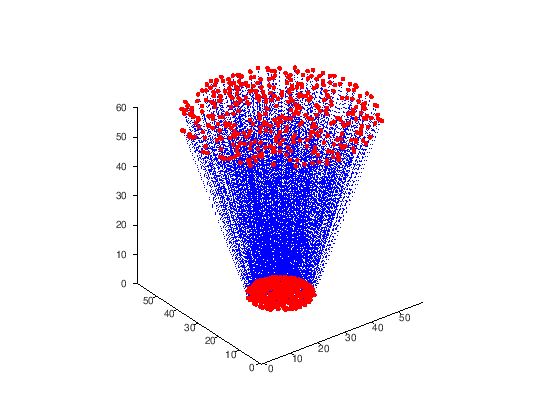

In [16]:
%%octave
sortedlines=mcxplotphotons(traj, 'color','b', 'linestyle', ':', 'markersize', 10, 'markeredgecolor', 'r');
axis equal
[sortedlines.id(1:10) sortedlines.pos(1:10,:)]

# » Choosing different source type


## Supported source types


---


MCX supports over a dozen source types. The source type can be set by the `cfg.srctype` field (a string), and the parameters for the source by `cfg.srcparam1` and `cfg.srcparam2` - each being a row-vector of 4 numbers. The supported source types are listed below

- `'pencil'` - default, pencil beam, no param needed
- `'isotropic'` - isotropic source, no param needed
- `'cone'` - uniform cone beam, `srcparam1(1)` is the half-angle in radian
- `'gaussian'` [*] - a collimated gaussian beam, `srcparam1(1)` specifies the waist radius (in voxels)
- `'hyperboloid'` - a one-sheeted hyperboloid gaussian beam, `srcparam1(1)` specifies the waist
  radius (in voxels), `srcparam1(2)` specifies distance between launch plane and focus,
  `srcparam1(3)` specifies rayleigh range
- `'planar'` [\*] - a 3D quadrilateral uniform planar source, with three corners specified 
   by srcpos, `srcpos+srcparam1(1:3)` and `srcpos+srcparam2(1:3)`
- `'pattern'` [\*] - a 3D quadrilateral pattern illumination, same as above, except
   `srcparam1(4)` and `srcparam2(4)` specify the pattern array x/y dimensions,
   and srcpattern is a floating-point pattern array, with values between [0-1]. 
   if cfg.srcnum>1, srcpattern must be a floating-point array with 
   a dimension of `[srcnum srcparam1(4) srcparam2(4)]`
- `'pattern3d'` [\*] - a 3D illumination pattern. srcparam1{x,y,z} defines the dimensions,
   and srcpattern is a floating-point pattern array, with values between [0-1]. 
- `'fourier'` [\*] - spatial frequency domain source, similar to 'planar', except
   the integer parts of `srcparam1(4)` and `srcparam2(4)` represent
   the x/y frequencies; the fraction part of srcparam1(4) multiplies
   2*pi represents the phase shift (phi0); 1.0 minus the fraction part of
   `srcparam2(4)` is the modulation depth (M). Put in equations:
   `S=0.5*[1+M*cos(2*pi*(fx*x+fy*y)+phi0)]`, (`0<=x,y,M<=1`)
- `'arcsine'` - similar to isotropic, except the zenith angle is uniform
   distribution, rather than a sine distribution.
- `'disk'` [\*] - a uniform disk source pointing along srcdir; the radius is 
  set by srcparam1(1) (in grid unit); if srcparam1(2) is set to a non-zero
  value, this source defines a ring (annulus) shaped source, with
  srcparam1(2) denoting the inner circle's radius, here `srcparam1(1)>=srcparam1(2)`
- `'fourierx'` [\*] - a general Fourier source, the parameters are 
  `srcparam1`: `[v1x,v1y,v1z,|v2|]`, `srcparam2`: `[kx,ky,phi0,M]`
  normalized vectors satisfy: `srcdir cross v1=v2`
  the phase shift is phi0*2*pi
- `'fourierx2d'` [\*] - a general 2D Fourier basis, parameters
  srcparam1: `[v1x,v1y,v1z,|v2|]`, srcparam2: `[kx,ky,phix,phiy]`
  the phase shift is phi{x,y}*2*pi
- `'zgaussian'` - an angular gaussian beam, srcparam1(1) specifies the variance in the zenith angle
- `'line'` - a line source, emitting from the line segment between 
  `cfg.srcpos` and `cfg.srcpos+cfg.srcparam(1:3)`, radiating 
  uniformly in the perpendicular direction
- `'slit'` [\*] - a colimated slit beam emitting from the line segment between 
  cfg.srcpos and `cfg.srcpos+cfg.srcparam(1:3)`, with the initial  
  dir specified by cfg.srcdir
- `'pencilarray'` - a rectangular array of pencil beams. The srcparam1 and srcparam2
  are defined similarly to 'fourier', except that `srcparam1(4)` and `srcparam2(4)`
  are both integers, denoting the element counts in the x/y dimensions, respectively. 
  For exp., `srcparam1=[10 0 0 4]` and `srcparam2[0 20 0 5]` represent a 4x5 pencil beam array
  spanning 10 grids in the x-axis and 20 grids in the y-axis (5-voxel spacing)

source types marked with [\*] can be focused using the
focal length parameter (4th element of `cfg.srcdir`)

## `isotropic` source

---


In [ ]:
%%octave

clear cfg
cfg.nphoton=800;
cfg.vol=uint8(ones(60,60,60));
cfg.srcpos=[30 30 30];
cfg.srcdir=[0 0 1];
cfg.prop=[0 0 1 1; 0.005 0 0 1];
cfg.tstart=0;
cfg.tend=1e-10;
cfg.tstep=1e-10;
cfg.isreflect=0;

cfg.maxjumpdebug=1e7;   % this flag sets the maximum scattering-site count for all simulated photons; mcx will stop recording when all total scattering events exceeds this number

cfg.srctype='isotropic';
[flux, detp, vol, seeds, traj]=mcxlab(cfg);

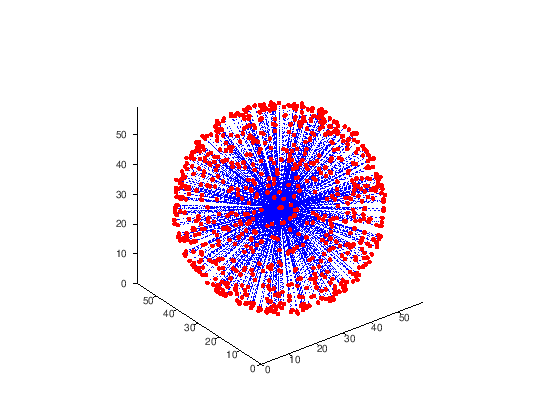

In [18]:
%%octave
title('isotropic source')
sortedlines=mcxplotphotons(traj, 'color','b', 'linestyle', ':', 'markersize', 10, 'markeredgecolor', 'r');
axis equal

## `cone` beam

---

In [ ]:
%%octave
cfg.srctype='cone';
cfg.srcpos=[30,30,0];
cfg.srcparam1=[pi/6, 0, 0, 0];

[flux, detp, vol, seeds, traj]=mcxlab(cfg);

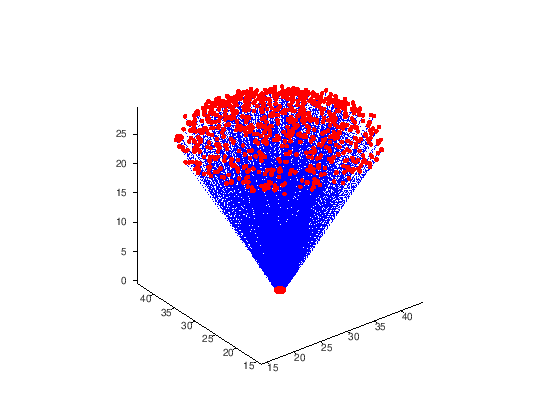

In [20]:
%%octave
title('cone source')
sortedlines=mcxplotphotons(traj, 'color','b', 'linestyle', ':', 'markersize', 10, 'markeredgecolor', 'r');
axis equal

## `disk` source - uniform disk beam

---


In [ ]:
%%octave
cfg.srctype='disk';
cfg.srcpos=[30,30,0];
cfg.srcparam1=[10, 0, 0, 0];

[flux, detp, vol, seeds, traj]=mcxlab(cfg);

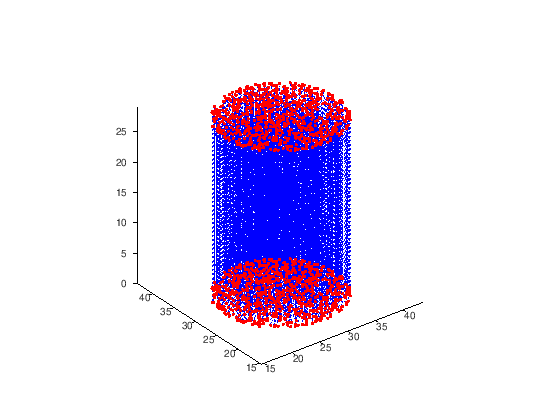

In [23]:
%%octave
title('disk source')
sortedlines=mcxplotphotons(traj, 'color','b', 'linestyle', ':', 'markeredgecolor', 'r');
axis equal

## `gaussian` source - colimated Gaussian beam

---


In [ ]:
%%octave
cfg.srctype='gaussian';
waist=10;    % Gaussian beam waist W0=2*sigma where sigma is the standard-deviation of the Gaussian profile
cfg.srcparam1=[waist, 0, 0, 0];
cfg.srcdir=[0,0,1];

[flux, detp, vol, seeds, traj]=mcxlab(cfg);

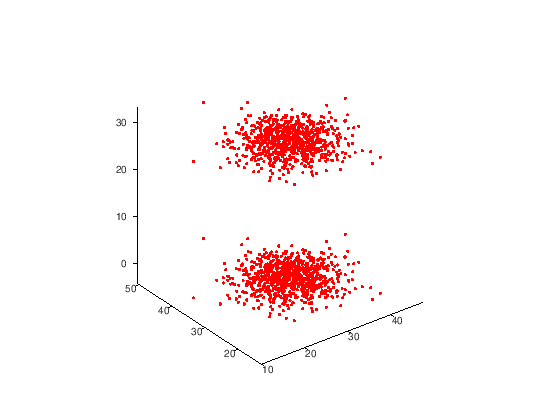

In [30]:
%%octave
title('colimated Gaussan beam source')
sortedlines=mcxplotphotons(traj, 'color','b', 'linestyle', 'none', 'markeredgecolor', 'r');
axis equal

## `zgaussian` source (angular Gaussian)

---


In [ ]:
%%octave
cfg.srctype='zgaussian';
sigma=pi/6;    % the first element of srcparam1 sets the standard deviation of the zenith angle
cfg.srcparam1=[sigma, 0, 0, 0];

[flux, detp, vol, seeds, traj]=mcxlab(cfg);

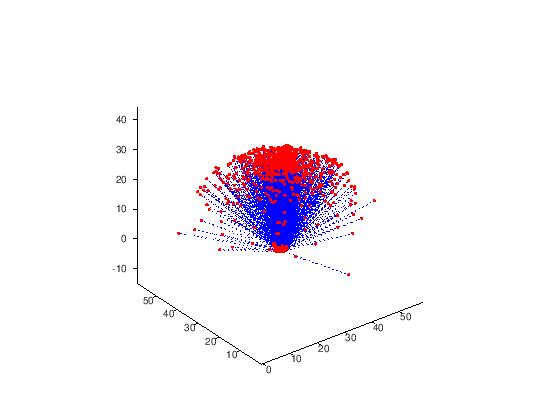

In [32]:
%%octave
title('angular Gaussan beam source')
sortedlines=mcxplotphotons(traj, 'color','b', 'linestyle', ':', 'markeredgecolor', 'r');
axis equal

## `line` source - uniform line source

---


In [ ]:
%%octave
cfg.srctype='line';
cfg.srcpos=[10,10,30];
cfg.srcparam1=[40, 30, 0, 0];
cfg.nphoton=1e3;

[flux, detp, vol, seeds, traj]=mcxlab(cfg);

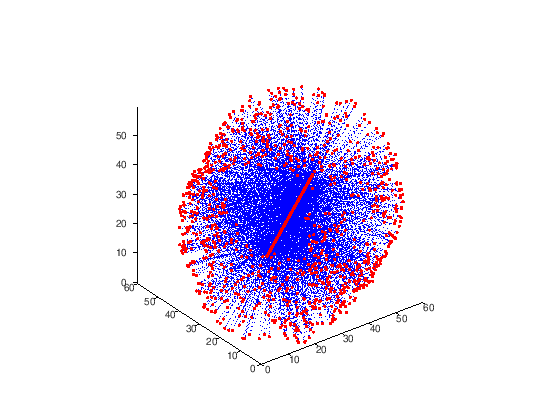

In [62]:
%%octave
title('line source')
sortedlines=mcxplotphotons(traj, 'color','b', 'linestyle', ':', 'markeredgecolor', 'r');
axis equal

## `slit` source - directed line source

---


In [ ]:
%%octave
cfg.srctype='slit';
cfg.srcpos=[20,10,0];
cfg.srcdir=[0,0,1];
cfg.srcparam1=[40, 30, 0, 0];

[flux, detp, vol, seeds, traj]=mcxlab(cfg);

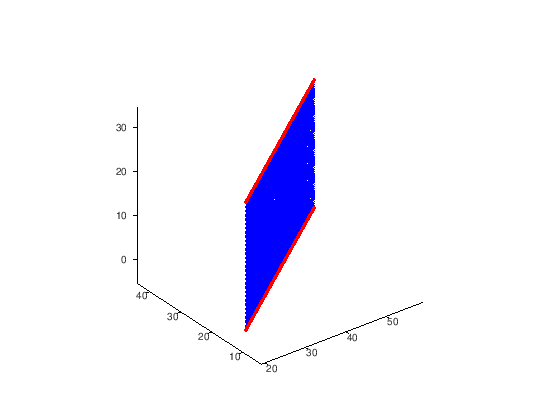

In [ ]:
%%octave
title('slit source')
sortedlines=mcxplotphotons(traj, 'color','b', 'linestyle', ':', 'markeredgecolor', 'r');
axis equal

## `planar` source - uniform rectangular/quadrilateral area source

---


In [ ]:
%%octave
cfg.srctype='planar';
cfg.srcpos=[10,10,0];
cfg.srcdir=[0,0,1];
cfg.srcparam1=[30, 0, 0, 0];   % cfg.srcpos+cfg.srcparam1(1:3) determines 
cfg.srcparam2=[0, 40, 0, 0];

[flux, detp, vol, seeds, traj1]=mcxlab(cfg);

cfg.srcparam1=[20, 10, 0, 0];   % cfg.srcpos+cfg.srcparam1(1:3) determines 
cfg.srcparam2=[15, 30, 0, 0];

[flux, detp, vol, seeds, traj2]=mcxlab(cfg);

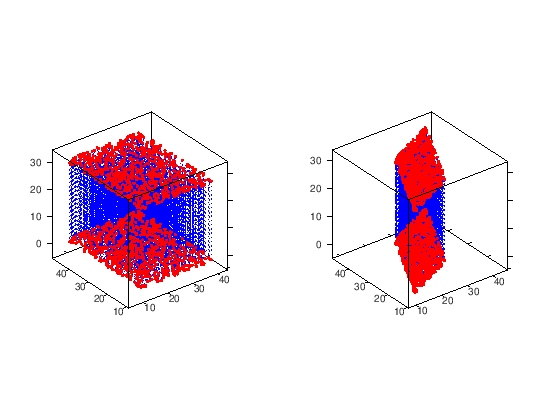

In [57]:
%%octave
subplot(121, 'position', [0 0 0.5 1]);
title('planar source')
sortedlines=mcxplotphotons(traj1, 'color','b', 'linestyle', ':', 'markeredgecolor', 'r');
box on;
axis equal

subplot(122, 'position', [0.5 0 0.5 1]);
title('quadrilateral source')
sortedlines=mcxplotphotons(traj, 'color','b', 'linestyle', ':', 'markeredgecolor', 'r');
box on;
axis equal